# Population dynamics

## For the fish
* At each chronon, a fish moves randomly to one of the adjacent unoccupied squares. If there are no free squares, no movement takes place.
* Once a fish has survived a certain number of chronons it may reproduce. This is done as it moves to a neighbouring square, leaving behind a new fish in its old position. Its reproduction time is also reset to zero.

## For the sharks
* At each chronon, a shark moves randomly to an adjacent square occupied by a fish. If there is none, the shark moves to a random adjacent unoccupied square. If there are no free squares, no movement takes place.
* At each chronon, each shark is deprived of a unit of energy.
* Upon reaching zero energy, a shark dies.
* If a shark moves to a square occupied by a fish, it eats the fish and earns a certain amount of energy.
* Once a shark has survived a certain number of chronons it may reproduce in exactly the same way as the fish.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import seaborn as sns

import imageio
import os

In [5]:
rdgn = sns.diverging_palette(h_neg=55, h_pos=255, s=99, l=55, n = 2, as_cmap=True)

In [6]:
class population:

    """
    Class: Population

    This keeps the body of the simulation. It contains the key methods (setup, update, and view). 
    Next methods to build include
    - metrics (how many fish and sharks after a iteration remain)
    - gif (how can i make one of those slick gifs like on the website?)
    """

    def __init__(self, size, fish, sharks):
        self.size = size
        self.fish = fish
        self.sharks = sharks
        self.grid = np.zeros((size, size))
        self.fish_n = [] #record the number of fish remaining
        self.sharks_n = [] #record the number of sharks remaining

    def empty_slots(self):
        return np.where(self.grid == 0)
    
    def setup(self):

        """
        method: setup - initialises the grid with fish and sharks. 
        Fish get initialised first in the empty slots. 
        Then the sharks get initialised into the empty slots.
        """

        # where are the empty slots on the grid
        empty_for_fish = self.empty_slots()

        #which indeces should the fish occupy
        fish_starters = rd.sample(range(0, len(empty_for_fish[0])), self.fish)

        #print(len(empty_for_fish[0]))
        #print(fish_starters)

        #for each sampled empty slot
        for position in fish_starters:

            #occupy it with a fish
            self.grid[empty_for_fish[0][position], empty_for_fish[1][position]] = 10

        #where do the shark fit
        empty_for_shark = self.empty_slots()

        #which indeces should the shark occupy
        shark_starters = rd.sample(range(0, len(empty_for_shark[0])), self.sharks)
        #print(len(empty_for_shark[0]))

        #for each sampled empty slot
        for position in shark_starters:

            #occupy it with a shark, the more negative, the better for the shark
            #The shark digit is separated
            # tens: shows the eating value, 
            # ones: shows the reproduction value
            self.grid[empty_for_shark[0][position], empty_for_shark[1][position]] = -30

    def view(self, iteration = None):

        """
        method: view - let's you print a heatmap of the fish and sharks.
        input:  Iteration = None. Pass an int to save images that can be converted to a gif. 
        """
        plt.figure()
        #get a heatmap for the grid
        sns.heatmap(self.grid, cmap=rdgn,center=0.00)
        plt.suptitle("Blue: Fish \n Yellow: Sharks") 
        plt.title(f"Iteration: {iteration}", loc='left')

        # in case we don't want to save an image we can just not specify an iteration
        if iteration != None:  
            plt.savefig(f'{iteration}.png')
            plt.close()
        else:
            plt.show() 
        
    def update(self):

        """
        method: update the simulation by one iteration
        input:  self
        output: updated grid

        We update the fish first by identifying all fish and iterating through them and moving them if there is space.
        They increase in their production value after each round. They reproduce if they get beyond 3 in reproduction value.

        Then sharks get updated with the rules set by the game. 
        """


        # updating the fish
        # where are my fish?
        fish_list = np.where(self.grid > 0)

        #for each fisch
        for fish in range(len(fish_list[0])):

            reproduction_value = self.grid[fish_list[0][fish], fish_list[1][fish]]
            
            free_spots = []
            #get a direction
            for direction in [((fish_list[0][fish] +1)%self.size, fish_list[1][fish]),  #up
            ((fish_list[0][fish] -1)%self.size, fish_list[1][fish]), #down 
            (fish_list[0][fish], (fish_list[1][fish] - 1)%self.size), #left
            (fish_list[0][fish], (fish_list[1][fish] + 1)%self.size)]: #right

                #is that spot free on our grid?
                if self.grid[direction[0], direction[1]] == 0:
                    free_spots.append(direction)

            #print(free_spots)

            #if there are no free spots
            if free_spots == []:

                self.grid[fish_list[0][fish], fish_list[1][fish]] += 10

            else:

                #choose a direction
                chosen_dir = rd.choice(free_spots)
                #print(chosen_dir)

                #check if we reproduce
                if reproduction_value < 30:
                    #move fish there
                    self.grid[chosen_dir[0], chosen_dir[1]] = reproduction_value + 10

                    #delete fish from old spot
                    self.grid[fish_list[0][fish], fish_list[1][fish]] = 0

                else:
                    #move fish there and reset reproduction value
                    self.grid[chosen_dir[0], chosen_dir[1]] = 10

                    #introduce the reproduced fish child
                    self.grid[fish_list[0][fish], fish_list[1][fish]] = 10

        #print(self.grid)


        #update the sharks

        #find my sharks 
        shark_list = np.where(self.grid < 0)

        #for each shark
        for shark in range(len(shark_list[0])):

            #get the shark value we are working with
            shark_value = self.grid[shark_list[0][shark], shark_list[1][shark]]
            
            #make lists with potential places to move to
            fish_spots = []
            free_spots = []
            
            #get a direction
            for direction in [((shark_list[0][shark] +1)%self.size, shark_list[1][shark]),  #up
            ((shark_list[0][shark] -1)%self.size, shark_list[1][shark]), #down 
            (shark_list[0][shark], (shark_list[1][shark] - 1)%self.size), #left
            (shark_list[0][shark], (shark_list[1][shark] + 1)%self.size)]: #right

                #is that spot free on our grid?
                if self.grid[direction[0], direction[1]] > 0:
                    fish_spots.append(direction)

                elif self.grid[direction[0], direction[1]] == 0:
                    free_spots.append(direction)

            #print('fs', fish_spots)

            #if there is a fish around 
            if len(fish_spots) != 0:

                #print("We ate a fish!")
                
                #choose a direction
                chosen_dir = rd.choice(fish_spots)
                #print('chosen dir', chosen_dir)
                #print("We ate a fish!", chosen_dir)

                #check if we reproduce (after five timesteps)
                if shark_value%-10 > -5:
                    
                    #move shark there
                    self.grid[chosen_dir[0], chosen_dir[1]] = shark_value - 11 #we subtract 10 for eating a fish and 1 to the reproduction clock

                    #delete shark from old spot
                    self.grid[shark_list[0][shark], shark_list[1][shark]] = 0

                else:
                    #move shark
                    #we reset the clock by getting rid of the ones and subract 10 for eating afish
                    self.grid[chosen_dir[0], chosen_dir[1]] = shark_value + (shark_value%10) -10 

                    #introduce the reproduced shark child
                    self.grid[shark_list[0][shark], shark_list[1][shark]] = -10

            #if there are no fish around
            elif len(free_spots) != 0:
                new_shark_val = shark_value + 9

                #check if shark died and we move on to the next shark
                if new_shark_val//-10 == 0:
                    self.grid[shark_list[0][shark], shark_list[1][shark]] = 0
                    #print('Shark died!')
                    continue 


                #choose free spot
                #choose a direction
                chosen_dir = rd.choice(free_spots)
                #print(chosen_dir)
                #print("Shark moved to empty spot", chosen_dir)
                
                #check if we reproduce (after five timesteps)
                if shark_value%-10 > -5:
                    #print("rep_val", shark_value%-10)

                    #move shark there
                    self.grid[chosen_dir[0], chosen_dir[1]] = shark_value + 9 #we add 10 for not eating a fish and subract 1 to increase the reproduction clock

                    #delete shark from old spot
                    self.grid[shark_list[0][shark], shark_list[1][shark]] = 0

                else:
                    #move shark
                    #we reset the clock by getting rid of the ones 
                    
                    self.grid[chosen_dir[0], chosen_dir[1]] = shark_value + (shark_value%10) + 10 #we move the shark and punish it for not eating 

                    #a new shark is born
                    self.grid[shark_list[0][shark], shark_list[1][shark]] = -10 


            #shark stays in the same spot 
            else:

                #print("shark stayed in the same spot")
                new_shark_val = shark_value + 9

                #check if shark died and we move on to the next shark
                if new_shark_val//-10 == 0:
                    self.grid[shark_list[0][shark], shark_list[1][shark]] = 0
                    continue 

                #leave shark, let him have -1 for reproduction and +10 for not eating
                self.grid[shark_list[0][shark], shark_list[1][shark]] = shark_value + 9

    def record(self):
        """
        method:     Records the number of fish and sharks

        inputs:     none
        outputs:    Bool whether there is life in the grid.
        """
        
        #record the number of fish
        self.fish_n.append(len(np.where(self.grid > 0)[0]))

        #record the number of sharks
        self.sharks_n.append(len(np.where(self.grid < 0)[0]))

        if self.fish_n[-1] > 0 and self.sharks_n[-1] > 0:
            return True
        else: 
            return False


            

               


In [7]:

def run_simulation(grid_size, initial_fish, initial_sharks, length_of_sim, generate_gif = True):

    """
    func:   Runs the whole simulation.
    inputs: grid_size: length of one side of the grid
            initial_fish: number of initial fish
            initial_sharks: number of initial sharks
            length_of_sim: max number of updates
    returns:an object of type class population
    """
    
    #generate population object
    sim = population(grid_size, initial_fish, initial_sharks)
    #set up
    sim.setup()

    #update up to the maximum length
    for sim_run in range(length_of_sim):
        sim.update()

        #record fish and sharks
        alive = sim.record()

        # if we want build the gif
        if generate_gif:
            sim.view(sim_run)

        #check if still alive
        if alive == False:
            #if not alive end simulation
            break
    #print(f"simulation terminated after {sim_run + 1} runs")

    #return the max sim run 
    return sim, sim_run


In [22]:
def make_gif(length_sim, n_frames = 5):

    """
    func:   creates a gif of the heatmaps. There need to be images saved by the view method.
    input:  length_sim: number of completed runs of simulation
            n_frames: wait time to slow down gif. default = 5.
    output: saves a gif to wd.
    """

    with imageio.get_writer('mygif.gif', mode='I') as writer:
        filenames = [f"{name}.png" for name in range(length_sim+1)]
        for filename in filenames:
            image = imageio.imread(filename)

            for i in range(n_frames):
                writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

    return

## Grid search for stable simulation

In [56]:
#let's use a grid size of 10x10
s = 10
max_runs = 250

#input lists
param_list_fish = []
param_list_sharks = []

#output lists
metric_list_runs = []

stable_list = []


#from 1 to 50 fish in 5 steps 
for param_fish in range(5,75):

    #from 1 to 50 sharks in 5 steps
    for param_shark in range(1, 25):

        param_list_fish.append(param_fish)
        param_list_sharks.append(param_shark)

        #run simulation
        obj, runs = run_simulation(s, param_fish, param_shark, max_runs, generate_gif = False)
        metric_list_runs.append(runs)

        if runs + 1 == max_runs: 
            print(f"Simulation with {param_fish} fish and {param_shark} sharks had {runs + 1} runs.")

            stable_list.append([param_fish, param_shark, obj])



Text(0.5, 0, 'Runs')

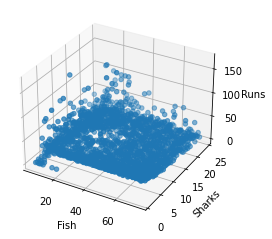

In [57]:

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection ='3d')

ax.scatter(param_list_fish, param_list_sharks, metric_list_runs)
ax.set_xlabel("Fish")
ax.set_ylabel("Sharks")
ax.set_zlabel("Runs")

There is no stable relationship yet with the currently defined rule. 
The next step would be to play with the other parameters:
- how often do fish reproduce?
- how often do shark reproduce?
- initial health of sharks?
- how much energy is reduced if shark doesn't eat and how much is added if they do? 
- how big is the grid -> I believe the grid is not that big a deal when shark and fish numbers are flexible because it just adjusts their free space. 

In [58]:
print(stable_list)
np.asarray(stable_list)[:,0] / np.asarray(stable_list)[:,1]

[]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [42]:
final_sim, sim_length = run_simulation(10,23,9,100)
make_gif(sim_length)


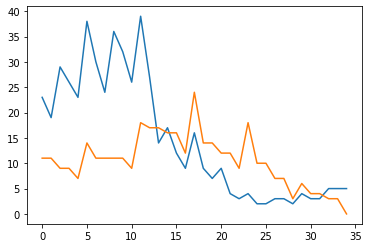

In [28]:
#rudimentary plot for monitoring fish and sharks
plt.plot([_ for _ in range(sim_length+1)], final_sim.fish_n)
plt.plot([_ for _ in range(sim_length+1)], final_sim.sharks_n)